<h1>Maritime: Weather</h1>

In [9]:
import pandas as pd
import numpy as np
from math import atan2, degrees
from datetime import datetime
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


# PATHS
AIS_COLLISION_CSV = "collision/ais raw data/gfw_encounters_recent.csv"
AIS_WEATHER_CSV = "weather/ais_weather.csv"
AIS_WEATHERAPI_CSV = "weather/ais_weatherapi.csv"

WIND_NC = "weather/wind10m.nc"
WAVES_NC = "weather/waves_subset.nc"
CURRENTS_NC = "weather/currents_subset.nc"

<h2>Retrieving Raw AIS Data Used In Collision to call Weather API to get data</h2>

In [10]:
df = pd.read_csv(AIS_COLLISION_CSV)

# --- choose timestamp ---
df["ts_utc"] = pd.to_datetime(df["start"], errors="coerce").dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# --- lat/lon ---
def parse_bbox(b):
    try:
        vals = [float(x) for x in str(b).strip("[]").split(",")]
        if len(vals) >= 2:
            # Heuristic: if |vals[0]| <= 90 and |vals[1]| <= 180, assume [lat, lon]
            if abs(vals[0]) <= 90 and abs(vals[1]) <= 180:
                return pd.Series({"lat_fallback": vals[0], "lon_fallback": vals[1]})
            else:
                # else assume [lon, lat]
                return pd.Series({"lat_fallback": vals[1], "lon_fallback": vals[0]})
    except Exception:
        pass
    return pd.Series({"lat_fallback": np.nan, "lon_fallback": np.nan})

bbox_fallback = df["boundingBox"].apply(parse_bbox)
df = pd.concat([df, bbox_fallback], axis=1)

df["lat"] = df["position__lat"].where(df["position__lat"].notna(), df["lat_fallback"])
df["lon"] = df["position__lon"].where(df["position__lon"].notna(), df["lon_fallback"])

# --- sog ---
df["sog"] = pd.to_numeric(df["encounter__medianSpeedKnots"], errors="coerce").round(1)

# --- drop mmsi null values ---
df['mmsi'] = df['vessel__ssvid']
df = df.dropna(subset=['mmsi'])

# --- vessel_type ---
df["vessel_type"] = df["vessel__type"].fillna("Unknown")

# --- compute COG by bearing to next point per vessel ---
# sort by vessel + time
df["_t"] = pd.to_datetime(df["ts_utc"], errors="coerce")
df = df.sort_values(["mmsi", "_t"])

# Bearing helper
def bearing_deg(lat1, lon1, lat2, lon2):
    if any(pd.isna([lat1, lon1, lat2, lon2])):
        return np.nan
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    y = np.sin(dlon) * np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    brng = (degrees(atan2(y, x)) + 360) % 360
    return brng

# Next point within same vessel
df["lat_next"] = df.groupby("mmsi")["lat"].shift(-1)
df["lon_next"] = df.groupby("mmsi")["lon"].shift(-1)

df["cog"] = df.apply(lambda r: bearing_deg(r["lat"], r["lon"], r["lat_next"], r["lon_next"]), axis=1)
df["cog"] = df["cog"].round(0).astype("Int64").astype(str).str.zfill(3)
df.loc[df["cog"]=="<NA>", "cog"] = ""

# --- final selection & cleaning ---
out = df[["ts_utc", "lat", "lon", "sog", "cog", "mmsi", "vessel_type"]].copy()
out = out.dropna(subset=["ts_utc", "lat", "lon"])
out["lat"] = out["lat"].round(3)
out["lon"] = out["lon"].round(3)

# save
out.to_csv(AIS_WEATHER_CSV, index=False)
print(out.head(5).to_string(index=False))


              ts_utc    lat     lon  sog cog  mmsi vessel_type
2025-03-21T08:20:00Z  9.833 107.688  0.0      1069     fishing
2025-03-20T01:50:00Z 33.813 122.005  0.2      4097     fishing
2025-03-21T00:20:00Z 21.302 114.259  1.7     11131     fishing
2025-03-20T15:20:00Z 22.139 117.150  0.2     21658     fishing
2025-03-21T07:50:00Z 12.185 109.224  0.2     22145     fishing


<h2>Calling copernicusmarine API and wind.f000 to get relevant weather data</h2>

In [11]:
def sample_vars_to_points(nc_path, ais_df, wanted):
    """
    Samples variables from an xarray dataset at AIS (time, lat, lon) points.
    - Works with 1-D or 2-D lat/lon.
    - Uses time selection only if there is a real time dimension; otherwise skips time.
    """
    if not nc_path or nc_path == "-" or not Path(nc_path).exists():
        return {}

    ds = xr.open_dataset(nc_path)

    # ---- find lat/lon names ----
    lat_name = next((n for n in ["latitude","lat","nav_lat"] if n in ds.variables or n in ds.coords), None)
    lon_name = next((n for n in ["longitude","lon","nav_lon"] if n in ds.variables or n in ds.coords), None)
    if not lat_name or not lon_name:
        raise SystemExit(f"Could not find lat/lon in coords={list(ds.coords)} vars={list(ds.data_vars)}")

    # ---- collapse 2-D lat/lon (y,x) to 1-D if separable ----
    latn, lonn = None, None
    if getattr(ds[lat_name], "ndim", 1) == 2 and "y" in ds.dims and "x" in ds.dims:
        lat2d = ds[lat_name].values
        lon2d = ds[lon_name].values
        lat1d = lat2d[:, 0]
        lon1d = lon2d[0, :]
        if np.allclose(lat2d, lat1d[:, None], equal_nan=True) and np.allclose(lon2d, lon1d[None, :], equal_nan=True):
            ds = ds.assign_coords(y=("y", lat1d), x=("x", lon1d))
            latn, lonn = "y", "x"
        else:
            raise SystemExit(
                "Field has non-separable 2D lat/lon. Re-export as regular 1D latitude/longitude NetCDF."
            )

    # Pick 1-D coord names (normal case or after collapsing)
    def pick1d(ds, cands):
        for c in cands:
            if (c in ds.coords or c in ds.dims) and getattr(ds[c], "ndim", 1) == 1:
                return c
        return None

    if latn is None: latn = pick1d(ds, ["latitude","lat","y"])
    if lonn is None: lonn = pick1d(ds, ["longitude","lon","x"])
    if latn is None or lonn is None:
        raise SystemExit(f"No 1-D lat/lon coords. Coords: {list(ds.coords)} | Dims: {list(ds.dims)}")

    # ---- time handling ----
    tdim = None
    for cand in ("time","valid_time","step"):
        if cand in ds.dims and getattr(ds[cand], "ndim", 1) == 1:
            tdim = cand
            break

    # If only one time slice, drop time dim
    if tdim and ds.dims.get(tdim, 0) == 1:
        ds = ds.isel({tdim: 0})
        tdim = None

    # keep only variables we actually have
    avail = [v for v in wanted if v in ds.variables]
    if not avail:
        return {}

    # sort coords if 1-D
    for c in ([tdim] if tdim else []) + [latn, lonn]:
        if c and c in ds.coords and getattr(ds[c], "ndim", 1) == 1:
            ds = ds.sortby(c)

    # build selection target
    target = {
        latn: xr.DataArray(ais_df["lat"].values, dims="points"),
        lonn: xr.DataArray(ais_df["lon"].values, dims="points"),
    }
    if tdim:
        target[tdim] = xr.DataArray(ais_df["ts_utc"].values, dims="points")

    sampled = ds[avail].sel(target, method="nearest")
    return {v: sampled[v].values for v in avail}


In [12]:
# === Load AIS FROM AIS_WEATHER_CSV and normalize ===

ais = pd.read_csv(AIS_WEATHER_CSV)

# rename common variants to standard names
rename_map = {}
if "timestamp" in ais.columns: rename_map["timestamp"] = "ts_utc"
if "Latitude"  in ais.columns: rename_map["Latitude"]  = "lat"
if "Longitude" in ais.columns: rename_map["Longitude"] = "lon"
if "SOG"       in ais.columns: rename_map["SOG"]       = "sog"
if "COG"       in ais.columns: rename_map["COG"]       = "cog"
ais = ais.rename(columns=rename_map)

# Required columns check
for col in ("ts_utc","lat","lon"):
    if col not in ais.columns:
        raise SystemExit(f"Missing AIS column: {col}")

# Parse time -> naive UTC (ns precision ok for xarray)
ais["ts_utc"] = pd.to_datetime(ais["ts_utc"], errors="coerce", utc=True).dt.tz_convert(None)

# Coerce numerics and cog (for trigo) and clean
for c in ("lat","lon","sog","cog"):
    if c in ais.columns:
        ais[c] = pd.to_numeric(ais[c], errors="coerce")


In [13]:
# === Sample environmental fields ===

waves = sample_vars_to_points(WAVES_NC,    ais, wanted=["VHM0","VMDR","VTM10","VTPK"])
currs = sample_vars_to_points(CURRENTS_NC, ais, wanted=["uo","vo","eastward_current","northward_current"])
wind  = sample_vars_to_points(WIND_NC,     ais, wanted=["u10","v10","UGRD_10maboveground","VGRD_10maboveground"])

out = ais.copy()

# Attach samples if present
for k, v in waves.items(): out[k] = v
for k, v in currs.items(): out[k] = v
for k, v in wind.items():  out[k] = v

# Standardize aliases
if "UGRD_10maboveground" in out.columns: out = out.rename(columns={"UGRD_10maboveground":"u10"})
if "VGRD_10maboveground" in out.columns: out = out.rename(columns={"VGRD_10maboveground":"v10"})
if "eastward_current"    in out.columns: out = out.rename(columns={"eastward_current":"uo"})
if "northward_current"   in out.columns: out = out.rename(columns={"northward_current":"vo"})


C:\Users\lauxi\AppData\Local\Temp\ipykernel_23512\2802190509.py:53: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if tdim and ds.dims.get(tdim, 0) == 1:
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
C:\Users\lauxi\AppData\Local\Temp\ipykernel_23512\2802190509.py:53: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if tdim and ds.dims.get(tdim, 0) == 1:
<frozen _coll

In [14]:
# === Derived features ===

# Waves
if "VHM0" in out.columns:
    out["stormy"] = (out["VHM0"] >= 3.0).astype(int)

# Relative wave angle / sector (needs VMDR and COG)
if {"VMDR","cog"}.issubset(out.columns):
    # VMDR = mean wave direction (from-direction). Convert to “to” direction to compare with COG.
    wave_to = (out["VMDR"] + 180) % 360
    ang = np.abs((wave_to - out["cog"]) % 360)
    ang = np.where(ang > 180, 360 - ang, ang)
    out["rel_wave_angle"] = ang
    out["sea_sector"] = pd.cut(
        out["rel_wave_angle"],
        bins=[-0.1, 30, 150, 180],
        labels=["following", "beam", "head"]
    )

# Currents projection into along/cross relative to COG
if {"uo","vo","cog"}.issubset(out.columns):
    theta = np.deg2rad(out["cog"])
    hx, hy = np.sin(theta), np.cos(theta)  # heading unit vector (x=east, y=north)
    along_ms = out["uo"] * hx + out["vo"] * hy
    cross_ms = -out["uo"] * hy + out["vo"] * hx
    out["along_current_kn"] = along_ms * 1.94384
    out["cross_current_kn"] = cross_ms * 1.94384
    if "sog" in out.columns:
        out["stw_est_kn"] = out["sog"] - out["along_current_kn"]  # crude STW estimate

# Wind speed/dir and relative wind angle
if {"u10","v10"}.issubset(out.columns):
    out["wind_speed_ms"] = np.hypot(out["u10"], out["v10"])
    # “wind-to” direction (0=N, 90=E) using arctan2(u_east, v_north)
    out["wind_dir_to"] = (np.degrees(np.arctan2(out["u10"], out["v10"])) + 360) % 360
    if "cog" in out.columns:
        wang = (out["wind_dir_to"] - out["cog"]) % 360
        out["rel_wind_angle"] = np.where(wang > 180, 360 - wang, wang)


In [15]:
# === Save to your desired output ===
out.to_csv(AIS_WEATHERAPI_CSV, index=False)
print("Wrote", AIS_WEATHERAPI_CSV, "with shape", out.shape)

Wrote weather/ais_weatherapi.csv with shape (8000, 23)


<h2>Checking new csv file</h2>

In [16]:
df = pd.read_csv(AIS_WEATHERAPI_CSV)

print(df.shape, df.columns.tolist())
df.describe(include='all').T.head(20)

# essential fields present
assert {"ts_utc","lat","lon"}.issubset(df.columns)
# lat/lon sanity
assert df["lat"].between(-90,90).all()
assert df["lon"].between(-180,180).all()
df.isna().mean().sort_values(ascending=False).head(15)


(8000, 23) ['ts_utc', 'lat', 'lon', 'sog', 'cog', 'mmsi', 'vessel_type', 'VHM0', 'VMDR', 'VTM10', 'uo', 'vo', 'u10', 'v10', 'stormy', 'rel_wave_angle', 'sea_sector', 'along_current_kn', 'cross_current_kn', 'stw_est_kn', 'wind_speed_ms', 'wind_dir_to', 'rel_wind_angle']


stw_est_kn          0.778750
cross_current_kn    0.778750
along_current_kn    0.778750
sea_sector          0.778750
rel_wave_angle      0.778750
vo                  0.468250
uo                  0.468250
VHM0                0.468250
VTM10               0.468250
VMDR                0.468000
rel_wind_angle      0.347125
cog                 0.347125
lat                 0.000000
u10                 0.000000
v10                 0.000000
dtype: float64

In [17]:
# sorting by time (ts_utc)
df["_t"] = pd.to_datetime(df["ts_utc"], errors="coerce")
df = df.sort_values("_t")

In [18]:
df.head()

,ts_utc,lat,lon,sog,cog,mmsi,vessel_type,VHM0,VMDR,VTM10,...,stormy,rel_wave_angle,sea_sector,along_current_kn,cross_current_kn,stw_est_kn,wind_speed_ms,wind_dir_to,rel_wind_angle,_t
5773,2025-03-08 06:20:00,19.502,57.741,0.0,332.0,412549027,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,5.479104,18.27066,46.270660,2025-03-08 06:20:00
5768,2025-03-08 06:20:00,19.502,57.741,0.0,328.0,412549025,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,5.479104,18.27066,50.270660,2025-03-08 06:20:00
348,2025-03-10 05:30:00,19.481,57.730,0.0,90.0,271072244,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,5.479104,18.27066,71.729340,2025-03-10 05:30:00
6457,2025-03-10 05:30:00,19.481,57.730,0.0,247.0,461000153,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,5.479104,18.27066,131.270660,2025-03-10 05:30:00
459,2025-03-10 20:00:00,48.393,-64.493,0.0,90.0,316008008,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,5.243527,81.63434,8.365662,2025-03-10 20:00:00


In [19]:
# describing df to see statistics BEFORE data cleaning
df.describe()

,lat,lon,sog,cog,mmsi,VHM0,VMDR,VTM10,uo,vo,...,v10,stormy,rel_wave_angle,along_current_kn,cross_current_kn,stw_est_kn,wind_speed_ms,wind_dir_to,rel_wind_angle,_t
count,8000.000000,8000.000000,8000.000000,5223.000000,8.000000e+03,4254.000000,4256.000000,4254.000000,4254.000000,4254.000000,...,8000.000000,8000.0,1770.000000,1770.000000,1770.000000,1770.000000,8000.000000,8000.000000,5223.000000,8000
mean,24.571532,84.540630,0.290100,177.781160,4.347125e+08,0.518867,308.072680,6.839492,-0.129152,0.010502,...,-0.337662,0.0,92.130966,-0.003739,0.019949,0.278880,4.704372,171.391812,90.317412,2025-03-20 15:02:14.550000128
min,-60.699000,-176.036000,0.000000,0.000000,1.069000e+03,0.190000,114.910001,4.410000,-0.234490,0.006328,...,-8.617119,0.0,0.130003,-1.102532,-0.253710,-0.348238,0.731341,0.188416,0.045074,2025-03-08 06:20:00
25%,22.154750,50.033000,0.000000,90.000000,4.037835e+08,0.520000,309.869997,6.860000,-0.130368,0.006328,...,-3.787119,0.0,46.869997,-0.167188,-0.162332,-0.095496,3.800806,88.004456,46.863892,2025-03-20 08:50:00
50%,26.548000,106.661000,0.000000,167.000000,4.120069e+08,0.520000,309.869997,6.860000,-0.130368,0.006328,...,-1.087119,0.0,100.500000,0.012300,0.019906,0.116055,3.800806,184.863890,91.641418,2025-03-20 19:40:00
75%,26.549000,120.123500,0.200000,283.000000,4.152211e+08,0.520000,309.869997,6.860000,-0.130368,0.006328,...,3.087881,0.0,130.012499,0.167188,0.215418,0.253414,5.607487,196.826230,133.136108,2025-03-21 03:00:00
max,67.492000,175.829000,2.000000,360.000000,1.000840e+09,0.710000,309.869997,6.860000,0.184563,0.854749,...,8.882881,0.0,179.869997,0.348238,1.104952,2.250434,16.781473,359.586240,179.863892,2025-03-21 13:30:00
std,10.529967,39.492526,0.572969,107.742063,1.215335e+08,0.020793,16.764738,0.195890,0.016392,0.048146,...,3.876915,0.0,51.239600,0.175093,0.186950,0.582795,1.692266,95.981188,51.410642,NaN


In [20]:
# prints the number of null values in each column
null_counts = df.isnull().sum()
print(null_counts)

ts_utc                 0
lat                    0
lon                    0
sog                    0
cog                 2777
mmsi                   0
vessel_type            0
VHM0                3746
VMDR                3744
VTM10               3746
uo                  3746
vo                  3746
u10                    0
v10                    0
stormy                 0
rel_wave_angle      6230
sea_sector          6230
along_current_kn    6230
cross_current_kn    6230
stw_est_kn          6230
wind_speed_ms          0
wind_dir_to            0
rel_wind_angle      2777
_t                     0
dtype: int64


In [21]:
df.shape

(8000, 24)

<h2>Cleaning Data</h2>

Numeric columns found: ['lat', 'lon', 'sog', 'cog', 'mmsi', 'VHM0', 'VMDR', 'VTM10', 'uo', 'vo', 'u10', 'v10', 'stormy', 'rel_wave_angle', 'along_current_kn', 'cross_current_kn', 'stw_est_kn', 'wind_speed_ms', 'wind_dir_to', 'rel_wind_angle']
Columns for boxplot analysis: ['lat', 'lon', 'sog', 'cog', 'VHM0', 'VMDR', 'VTM10', 'uo', 'vo', 'u10', 'v10', 'stormy', 'rel_wave_angle', 'along_current_kn', 'cross_current_kn', 'stw_est_kn', 'wind_speed_ms', 'wind_dir_to', 'rel_wind_angle']


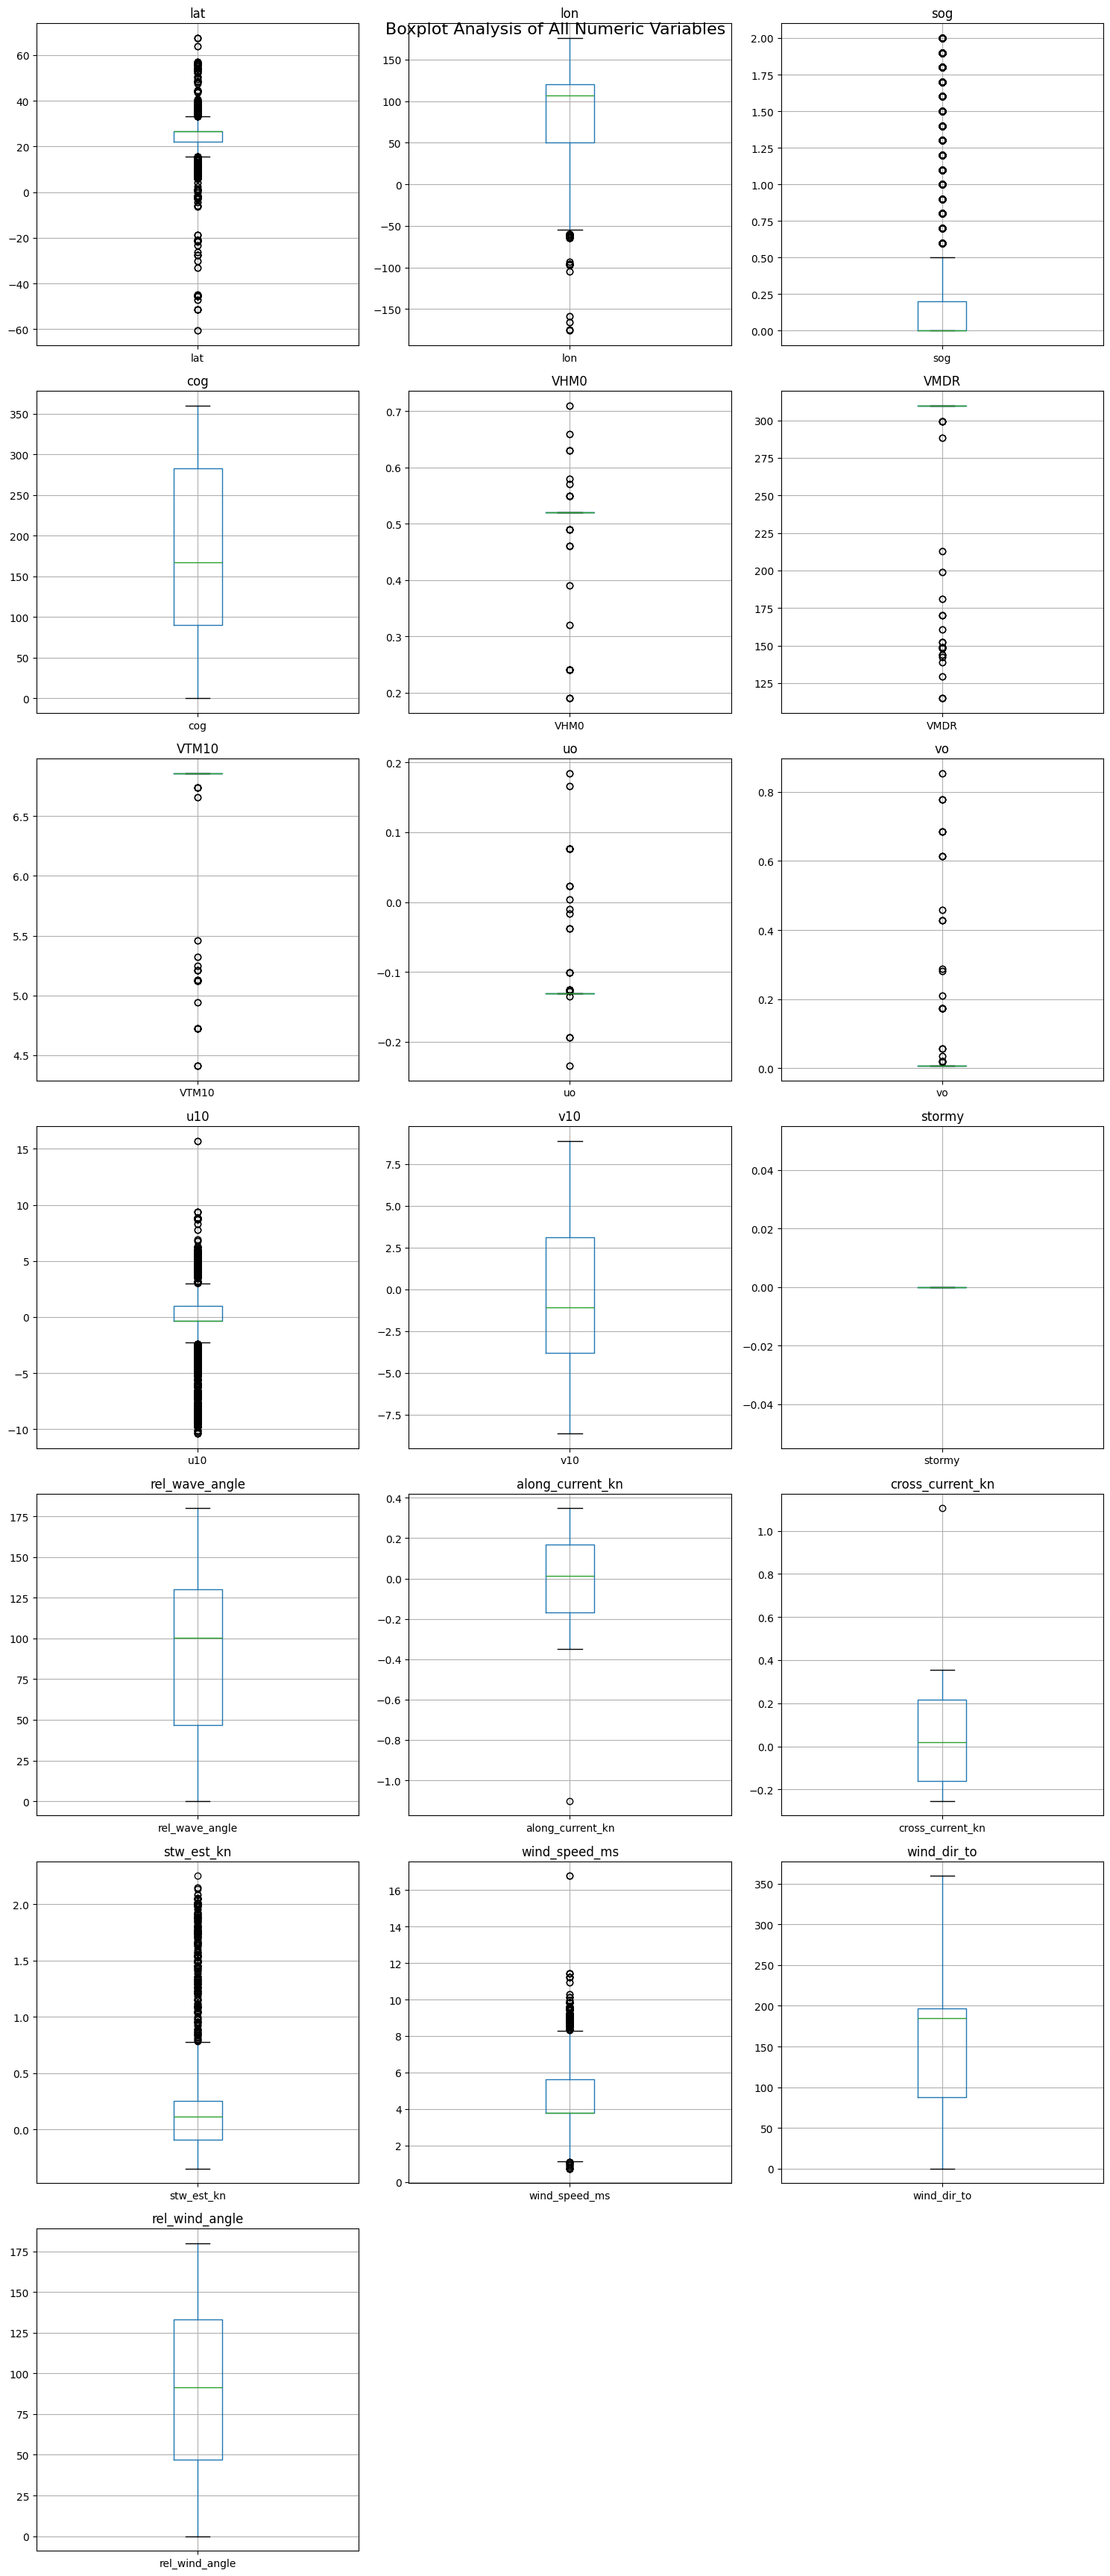

In [22]:
# Comprehensive boxplot analysis

# Get all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns found: {numeric_cols}")

# Remove ID-like columns and timestamps for visualization
exclude_cols = ['mmsi']  # MMSI is an identifier, not meaningful for distribution analysis
viz_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Columns for boxplot analysis: {viz_cols}")

# Create figure with subplots for better visualization
n_cols = len(viz_cols)
fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
fig.suptitle('Boxplot Analysis of All Numeric Variables', fontsize=16)

# Flatten axes for easier indexing
if n_cols > 3:
    axes = axes.flatten()
elif n_cols <= 3:
    axes = [axes] if n_cols == 1 else axes

for i, col in enumerate(viz_cols):
    if i < len(axes):
        df.boxplot(column=col, ax=axes[i])
        axes[i].set_title(f'{col}')
        axes[i].grid(True)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



In [23]:
# outliers shown in the boxplot are not removed as we find them to be crucial to our analysis
# they represent extreme weather conditions which are important for our study

# Detailed statistical analysis for imputation strategy
from scipy import stats

def analyze_column_distribution(df, col):
    """Analyze a column's distribution to determine best imputation method"""
    data = df[col].dropna()
    
    if len(data) == 0:
        return {"column": col, "strategy": "drop", "reason": "All values are missing"}
    
    # Basic statistics
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    
    # Skewness
    skewness = stats.skew(data)
    
    # Outliers using IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_percentage = len(outliers) / len(data) * 100
    
    # Missing value percentage
    missing_percentage = df[col].isna().sum() / len(df) * 100
    
    # Initialize strategy with default value
    strategy = "median"  # Default strategy
    reason = "Default median imputation"
    
    # Determine best imputation strategy
    if missing_percentage > 50:
        strategy = "consider_dropping"
        reason = f"High missing rate ({missing_percentage:.1f}%)"
    elif abs(skewness) < 0.5:  # Roughly normal distribution
        if outlier_percentage < 5:
            strategy = "mean"
            reason = "Normal distribution, low outliers"
        else:
            strategy = "median"
            reason = "Normal distribution, but high outliers"
    elif abs(skewness) >= 0.5:  # Skewed distribution
        strategy = "median"
        reason = f"Skewed distribution (skew={skewness:.2f})"
    
    return {
        "column": col,
        "missing_pct": missing_percentage,
        "mean": mean_val,
        "median": median_val,
        "std": std_val,
        "skewness": skewness,
        "outlier_pct": outlier_percentage,
        "strategy": strategy,
        "reason": reason
    }

# Analyze all numeric columns
analysis_results = []
for col in viz_cols:
    result = analyze_column_distribution(df, col)
    analysis_results.append(result)

# Create summary DataFrame
analysis_df = pd.DataFrame(analysis_results)
print("Distribution Analysis Summary:")
print("=" * 80)
print(analysis_df.round(3).to_string(index=False))
print("\n" + "=" * 80)

Distribution Analysis Summary:
          column  missing_pct    mean  median     std  skewness  outlier_pct          strategy                            reason
             lat        0.000  24.572  26.548  10.530    -1.940       30.650            median  Skewed distribution (skew=-1.94)
             lon        0.000  84.541 106.661  39.493    -0.954        0.950            median  Skewed distribution (skew=-0.95)
             sog        0.000   0.290   0.000   0.573     1.847       19.500            median   Skewed distribution (skew=1.85)
             cog       34.712 177.781 167.000 107.742    -0.046        0.000              mean Normal distribution, low outliers
            VHM0       46.825   0.519   0.520   0.021   -11.533        1.175            median Skewed distribution (skew=-11.53)
            VMDR       46.800 308.073 309.870  16.765    -9.479        1.316            median  Skewed distribution (skew=-9.48)
           VTM10       46.825   6.839   6.860   0.196    -9.778   

In [24]:
# === ANGLE CLEANING: Convert to Sin/Cos ===
# for circular variables like angles, converting to sin/cos representation helps avoid discontinuities

print("=== CONVERTING ANGLES TO SIN/COS ===")
df_clean = df.copy()

# Identify angle columns (in degrees)
angle_columns = ['cog', 'VMDR', 'wind_dir_to', 'rel_wave_angle', 'rel_wind_angle']

# Create sin/cos pairs for each angle
for col in angle_columns:
    if col in df_clean.columns:
        # Convert degrees to radians, then to sin/cos
        radians = np.deg2rad(df_clean[col])
        
        # Create sin and cos columns
        df_clean[f'{col}_sin'] = np.sin(radians)
        df_clean[f'{col}_cos'] = np.cos(radians)
        
        print(f"Converted {col} → {col}_sin, {col}_cos")

# Drop original angle columns (they're now redundant)
angles_to_drop = [col for col in angle_columns if col in df_clean.columns]
df_clean_angles = df_clean.drop(columns=angles_to_drop)

print(f"Dropped original angle columns: {angles_to_drop}")
print(f"New shape: {df_clean_angles.shape}")

=== CONVERTING ANGLES TO SIN/COS ===
Converted cog → cog_sin, cog_cos
Converted VMDR → VMDR_sin, VMDR_cos
Converted wind_dir_to → wind_dir_to_sin, wind_dir_to_cos
Converted rel_wave_angle → rel_wave_angle_sin, rel_wave_angle_cos
Converted rel_wind_angle → rel_wind_angle_sin, rel_wind_angle_cos
Dropped original angle columns: ['cog', 'VMDR', 'wind_dir_to', 'rel_wave_angle', 'rel_wind_angle']
New shape: (8000, 29)


In [25]:
# Smart filling of NA values based on distribution analysis

print("Applying intelligent imputation strategies:")
print("=" * 50)

# Apply imputation strategies based on analysis
for result in analysis_results:
    col = result['column']
    strategy = result['strategy']
    missing_pct = result['missing_pct']
    
    if col not in df_clean.columns:
        continue
        
    if missing_pct == 0:
        print(f"{col}: No missing values")
        continue
        
    original_nulls = df_clean[col].isnull().sum()
    
    if strategy == "mean":
        fill_value = df_clean[col].mean()
        df_clean[col].fillna(fill_value, inplace=True)
        print(f"{col}: Filled {original_nulls} values with MEAN ({fill_value:.3f}) - {result['reason']}")
        
    elif strategy == "median":
        fill_value = df_clean[col].median()
        df_clean[col].fillna(fill_value, inplace=True)
        print(f"{col}: Filled {original_nulls} values with MEDIAN ({fill_value:.3f}) - {result['reason']}")
        
    elif strategy == "consider_dropping":
        print(f"{col}: HIGH MISSING RATE ({missing_pct:.1f}%) - Consider dropping this column")
        # For now, we'll still fill with median but flag it
        fill_value = df_clean[col].median()
        # Continue from where your imputation code left off...

        df_clean[col].fillna(fill_value, inplace=True)
        print(f"  └─ Temporarily filled with median ({fill_value:.3f})")

print("\n" + "=" * 50)
print("Final null counts after imputation:")
null_counts = df_clean.isnull().sum()
print(null_counts[null_counts > 0])

if null_counts.sum() == 0:
    print("✓ All numeric columns successfully imputed!")
else:
    print(f"⚠ Still have {null_counts.sum()} null values remaining")

# === APPLY ANGLE CLEANING TO IMPUTED DATA ===
print("\n=== APPLYING ANGLE CLEANING ===")

# Work with the cleaned data from imputation
df_work = df_clean.copy()

# Identify angle columns (in degrees)
angle_columns = ['cog', 'VMDR', 'wind_dir_to', 'rel_wave_angle', 'rel_wind_angle']

# Create sin/cos pairs for each angle
for col in angle_columns:
    if col in df_work.columns:
        # Convert degrees to radians, then to sin/cos
        radians = np.deg2rad(df_work[col])
        
        # Create sin and cos columns
        df_work[f'{col}_sin'] = np.sin(radians)
        df_work[f'{col}_cos'] = np.cos(radians)
        
        print(f"Converted {col} → {col}_sin, {col}_cos")

# Drop original angle columns (they're now redundant)
angles_to_drop = [col for col in angle_columns if col in df_work.columns]
df_angles_clean = df_work.drop(columns=angles_to_drop)

print(f"Dropped original angle columns: {angles_to_drop}")
print(f"New shape after angle cleaning: {df_angles_clean.shape}")


Applying intelligent imputation strategies:
lat: No missing values
lon: No missing values
sog: No missing values
cog: Filled 2777 values with MEAN (177.781) - Normal distribution, low outliers
VHM0: Filled 3746 values with MEDIAN (0.520) - Skewed distribution (skew=-11.53)
VMDR: Filled 3744 values with MEDIAN (309.870) - Skewed distribution (skew=-9.48)
VTM10: Filled 3746 values with MEDIAN (6.860) - Skewed distribution (skew=-9.78)
uo: Filled 3746 values with MEDIAN (-0.130) - Skewed distribution (skew=12.93)
vo: Filled 3746 values with MEDIAN (0.006) - Skewed distribution (skew=13.42)
u10: No missing values
v10: No missing values
stormy: No missing values
rel_wave_angle: HIGH MISSING RATE (77.9%) - Consider dropping this column
  └─ Temporarily filled with median (100.500)
along_current_kn: HIGH MISSING RATE (77.9%) - Consider dropping this column
  └─ Temporarily filled with median (0.012)
cross_current_kn: HIGH MISSING RATE (77.9%) - Consider dropping this column
  └─ Temporarily f

C:\Users\lauxi\AppData\Local\Temp\ipykernel_23512\2833928406.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(fill_value, inplace=True)
C:\Users\lauxi\AppData\Local\Temp\ipykernel_23512\2833928406.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [26]:
#one-hot encoding for categorical variables
print("\n=== ONE-HOT ENCODING ===")

# Identify categorical columns to encode
categorical_cols = ["vessel_type", "sea_sector"]
available_categorical = [col for col in categorical_cols if col in df_angles_clean.columns]

print(f"Categorical columns found: {available_categorical}")

if available_categorical:
    df_encoded = pd.get_dummies(df_angles_clean, columns=available_categorical, drop_first=True)
    print(f"One-hot encoded columns: {available_categorical}")
    
    # Show new columns created
    new_cols = [col for col in df_encoded.columns if col not in df_angles_clean.columns]
    print(f"New binary columns created: {new_cols}")
else:
    df_encoded = df_angles_clean.copy()
    print("No categorical columns found for encoding")

print(f"Shape after encoding: {df_encoded.shape}")


=== ONE-HOT ENCODING ===
Categorical columns found: ['vessel_type', 'sea_sector']
One-hot encoded columns: ['vessel_type', 'sea_sector']
New binary columns created: ['vessel_type_carrier', 'vessel_type_fishing', 'sea_sector_following', 'sea_sector_head']
Shape after encoding: (8000, 31)


In [27]:
# === STANDARD SCALING ===
print("\n=== STANDARD SCALING ===")
from sklearn.preprocessing import StandardScaler

# Identify columns to exclude from scaling
exclude_from_scaling = [
    'mmsi',           # Vessel identifier
    'ts_utc',         # Timestamp (string)
    '_t'              # Timestamp (datetime)
]

# Get numeric columns for scaling
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
cols_to_scale = [col for col in numeric_cols if col not in exclude_from_scaling]

print(f"Total numeric columns: {len(numeric_cols)}")
print(f"Columns to scale: {len(cols_to_scale)}")
print(f"Excluded from scaling: {[col for col in exclude_from_scaling if col in df_encoded.columns]}")

# Apply StandardScaler
scaler = StandardScaler()
df_final = df_encoded.copy()

# Scale only the appropriate numeric columns
if cols_to_scale:
    df_final[cols_to_scale] = scaler.fit_transform(df_encoded[cols_to_scale])
    print("✓ Standard scaling completed")
else:
    print("⚠ No columns found for scaling")

print(f"Final dataset shape: {df_final.shape}")

# Verify scaling (mean ≈ 0, std ≈ 1)
print("\n=== SCALING VERIFICATION ===")
if cols_to_scale:
    scaling_check = df_final[cols_to_scale[:10]].describe().loc[['mean', 'std']]  # Check first 10 cols
    print("Sample of scaled columns (mean ≈ 0, std ≈ 1):")
    print(scaling_check.round(3))


=== STANDARD SCALING ===
Total numeric columns: 25
Columns to scale: 24
Excluded from scaling: ['mmsi', 'ts_utc', '_t']
✓ Standard scaling completed
Final dataset shape: (8000, 31)

=== SCALING VERIFICATION ===
Sample of scaled columns (mean ≈ 0, std ≈ 1):
      lat  lon  sog  VHM0  VTM10   uo   vo  u10  v10  stormy
mean -0.0 -0.0 -0.0  -0.0    0.0 -0.0  0.0 -0.0 -0.0     0.0
std   1.0  1.0  1.0   1.0    1.0  1.0  1.0  1.0  1.0     0.0


In [28]:
df_final.describe()

,lat,lon,sog,mmsi,VHM0,VTM10,uo,vo,u10,v10,...,cog_sin,cog_cos,VMDR_sin,VMDR_cos,wind_dir_to_sin,wind_dir_to_cos,rel_wave_angle_sin,rel_wave_angle_cos,rel_wind_angle_sin,rel_wind_angle_cos
count,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,...,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03
mean,-1.065814e-16,-2.273737e-16,-7.105427e-17,4.347125e+08,-1.305622e-15,3.074874e-15,-2.321698e-15,3.197442e-17,-1.598721e-17,-3.197442e-17,...,3.108624e-17,5.684342e-17,3.304024e-16,1.657341e-15,-1.421085e-17,6.039613e-17,-1.431744e-15,3.907985e-17,-2.557954e-16,-4.263256e-17
min,-8.098398e+00,-6.598538e+00,-5.063421e-01,1.069000e+03,-2.171218e+01,-1.703339e+01,-8.754897e+00,-6.311946e-02,-3.214272e+00,-2.135712e+00,...,-1.773417e+00,-8.984748e-01,-1.965109e+00,-1.432284e+01,-1.870240e+00,-9.558164e-01,-4.623853e+00,-2.513881e+00,-2.518611e+00,-1.769726e+00
25%,-2.295291e-01,-8.738308e-01,-5.063421e-01,4.037835e+08,3.971369e-02,7.615494e-02,-5.403907e-02,-6.311946e-02,7.047640e-03,-8.897984e-01,...,-6.191764e-01,-8.974837e-01,-7.353328e-02,7.890034e-02,-1.463847e-01,-9.514203e-01,3.832325e-01,-9.419539e-02,-5.402189e-01,-6.257380e-01
50%,1.877111e-01,5.601504e-01,-5.063421e-01,4.120069e+08,3.971369e-02,7.615494e-02,-5.403907e-02,-6.311946e-02,7.047640e-03,-1.933249e-01,...,4.871875e-02,-5.433732e-01,-7.353328e-02,7.890034e-02,-1.463847e-01,-5.859206e-02,3.832325e-01,-9.419539e-02,5.449779e-01,-2.776098e-03
75%,1.878060e-01,9.010589e-01,-1.572610e-01,4.152211e+08,3.971369e-02,7.615494e-02,-5.403907e-02,-6.311946e-02,4.333516e-01,8.836295e-01,...,5.807799e-01,1.002791e+00,-7.353328e-02,7.890034e-02,3.635764e-01,1.101305e+00,3.832325e-01,-9.419539e-02,7.600873e-01,6.322275e-01
max,4.076285e+00,2.311680e+00,2.984469e+00,1.000840e+09,1.256353e+01,7.615494e-02,2.626279e+01,2.406292e+01,5.151543e+00,2.378468e+00,...,1.735021e+00,1.745162e+00,1.729515e+01,7.890034e-02,1.896846e+00,1.485803e+00,4.686885e-01,3.403928e+00,7.601374e-01,1.783864e+00
std,1.000063e+00,1.000063e+00,1.000063e+00,1.215335e+08,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,...,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00


In [36]:
df_final.head()

,ts_utc,lat,lon,sog,mmsi,VHM0,VTM10,uo,vo,u10,...,wind_dir_to_sin,wind_dir_to_cos,rel_wave_angle_sin,rel_wave_angle_cos,rel_wind_angle_sin,rel_wind_angle_cos,vessel_type_carrier,vessel_type_fishing,sea_sector_following,sea_sector_head
5773,2025-03-08 06:20:00,-0.481469,-0.678642,-0.506342,412549027,0.039714,0.076155,-0.054039,-0.063119,0.660927,...,0.603829,1.424264,0.383232,-0.094195,-0.150060,1.235283,False,True,False,False
5768,2025-03-08 06:20:00,-0.481469,-0.678642,-0.506342,412549025,0.039714,0.076155,-0.054039,-0.063119,0.660927,...,0.603829,1.424264,0.383232,-0.094195,0.002388,1.142728,False,True,False,False
348,2025-03-10 05:30:00,-0.483463,-0.678921,-0.506342,271072244,0.039714,0.076155,-0.054039,-0.063119,0.660927,...,0.603829,1.424264,0.383232,-0.094195,0.594713,0.564104,False,True,False,False
6457,2025-03-10 05:30:00,-0.483463,-0.678921,-0.506342,461000153,0.039714,0.076155,-0.054039,-0.063119,0.660927,...,0.603829,1.424264,0.383232,-0.094195,-0.054938,-1.164939,False,True,False,False
459,2025-03-10 20:00:00,2.262396,-3.773953,-0.506342,316008008,0.039714,0.076155,-0.054039,-0.063119,1.773164,...,1.876840,0.442613,0.383232,-0.094195,-2.043791,1.764959,False,True,False,False


In [30]:
# === FINAL DATA QUALITY CHECK ===
print("\n" + "="*60)
print("FINAL DATA QUALITY SUMMARY")
print("="*60)

print(f"✓ Final dataset shape: {df_final.shape}")
print(f"✓ Total columns: {len(df_final.columns)}")

# Check for any remaining null values
total_nulls = df_final.isnull().sum().sum()
print(f"✓ Total null values: {total_nulls}")

# Data types summary
print(f"✓ Data types:")
dtype_counts = df_final.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   {dtype}: {count} columns")

# Sample of final data
print(f"\n✓ Sample of final cleaned data:")
print(df_final.head(3))

# Save the final cleaned dataset
final_csv_path = "weather/ais_weather_final_clean.csv"
df_final.to_csv(final_csv_path, index=False)
print(f"\n✓ Saved final cleaned dataset to: {final_csv_path}")

print("\n DATA CLEANING COMPLETE! Ready for clustering.")


FINAL DATA QUALITY SUMMARY
✓ Final dataset shape: (8000, 31)
✓ Total columns: 31
✓ Total null values: 0
✓ Data types:
   float64: 24 columns
   bool: 4 columns
   object: 1 columns
   int64: 1 columns
   datetime64[ns]: 1 columns

✓ Sample of final cleaned data:
                   ts_utc       lat       lon       sog       mmsi      VHM0  \
5773  2025-03-08 06:20:00 -0.481469 -0.678642 -0.506342  412549027  0.039714   
5768  2025-03-08 06:20:00 -0.481469 -0.678642 -0.506342  412549025  0.039714   
348   2025-03-10 05:30:00 -0.483463 -0.678921 -0.506342  271072244  0.039714   

         VTM10        uo        vo       u10  ...  wind_dir_to_sin  \
5773  0.076155 -0.054039 -0.063119  0.660927  ...         0.603829   
5768  0.076155 -0.054039 -0.063119  0.660927  ...         0.603829   
348   0.076155 -0.054039 -0.063119  0.660927  ...         0.603829   

      wind_dir_to_cos  rel_wave_angle_sin  rel_wave_angle_cos  \
5773         1.424264            0.383232           -0.094195   
5768

<h2>EDA</h2>

<h3>Peek into a Sample of the Data</h3>

Use `head` and `tail` to retrieve the top and bottom `n` rows. Use `sample` to randomly view (sample) `n` rows

In [31]:
df_final.head()

,ts_utc,lat,lon,sog,mmsi,VHM0,VTM10,uo,vo,u10,...,wind_dir_to_sin,wind_dir_to_cos,rel_wave_angle_sin,rel_wave_angle_cos,rel_wind_angle_sin,rel_wind_angle_cos,vessel_type_carrier,vessel_type_fishing,sea_sector_following,sea_sector_head
5773,2025-03-08 06:20:00,-0.481469,-0.678642,-0.506342,412549027,0.039714,0.076155,-0.054039,-0.063119,0.660927,...,0.603829,1.424264,0.383232,-0.094195,-0.150060,1.235283,False,True,False,False
5768,2025-03-08 06:20:00,-0.481469,-0.678642,-0.506342,412549025,0.039714,0.076155,-0.054039,-0.063119,0.660927,...,0.603829,1.424264,0.383232,-0.094195,0.002388,1.142728,False,True,False,False
348,2025-03-10 05:30:00,-0.483463,-0.678921,-0.506342,271072244,0.039714,0.076155,-0.054039,-0.063119,0.660927,...,0.603829,1.424264,0.383232,-0.094195,0.594713,0.564104,False,True,False,False
6457,2025-03-10 05:30:00,-0.483463,-0.678921,-0.506342,461000153,0.039714,0.076155,-0.054039,-0.063119,0.660927,...,0.603829,1.424264,0.383232,-0.094195,-0.054938,-1.164939,False,True,False,False
459,2025-03-10 20:00:00,2.262396,-3.773953,-0.506342,316008008,0.039714,0.076155,-0.054039,-0.063119,1.773164,...,1.876840,0.442613,0.383232,-0.094195,-2.043791,1.764959,False,True,False,False


In [32]:
df.tail()

,ts_utc,lat,lon,sog,cog,mmsi,vessel_type,VHM0,VMDR,VTM10,...,stormy,rel_wave_angle,sea_sector,along_current_kn,cross_current_kn,stw_est_kn,wind_speed_ms,wind_dir_to,rel_wind_angle,_t
3009,2025-03-21 13:30:00,26.548,50.033,0.0,324.0,403790940,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,3.800806,184.86389,139.136108,2025-03-21 13:30:00
3008,2025-03-21 13:30:00,26.548,50.033,0.0,0.0,403790940,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,3.800806,184.86389,175.136108,2025-03-21 13:30:00
567,2025-03-21 13:30:00,26.548,50.033,0.0,NaN,403156940,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,3.800806,184.86389,NaN,2025-03-21 13:30:00
1500,2025-03-21 13:30:00,26.548,50.033,0.0,NaN,403772940,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,3.800806,184.86389,NaN,2025-03-21 13:30:00
3011,2025-03-21 13:30:00,26.548,50.033,0.0,70.0,403790940,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,3.800806,184.86389,114.863892,2025-03-21 13:30:00


In [33]:
df.sample(5)

,ts_utc,lat,lon,sog,cog,mmsi,vessel_type,VHM0,VMDR,VTM10,...,stormy,rel_wave_angle,sea_sector,along_current_kn,cross_current_kn,stw_est_kn,wind_speed_ms,wind_dir_to,rel_wind_angle,_t
2866,2025-03-21 02:40:00,26.548,50.033,0.0,138.0,403789540,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,3.800806,184.863890,46.863892,2025-03-21 02:40:00
2408,2025-03-20 19:40:00,26.548,50.032,0.0,96.0,403786140,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,3.800806,184.863890,88.863892,2025-03-20 19:40:00
3657,2025-03-21 02:50:00,26.548,50.032,0.0,103.0,403794040,fishing,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,3.800806,184.863890,81.863892,2025-03-21 02:50:00
6814,2025-03-20 09:30:00,10.487,108.941,0.0,11.0,574093385,fishing,0.52,309.869997,6.86,...,0,118.869997,beam,-0.036279,0.251105,0.036279,4.409603,79.641420,68.641418,2025-03-20 09:30:00
4732,2025-03-21 03:40:00,34.974,120.798,0.9,317.0,412364442,fishing,0.52,309.869997,6.86,...,0,172.869997,head,0.181824,0.176946,0.718176,2.462064,28.049164,71.049164,2025-03-21 03:40:00


<h3>Summary Statistics</h3>

In [34]:
df_final.describe(include="all")

,ts_utc,lat,lon,sog,mmsi,VHM0,VTM10,uo,vo,u10,...,wind_dir_to_sin,wind_dir_to_cos,rel_wave_angle_sin,rel_wave_angle_cos,rel_wind_angle_sin,rel_wind_angle_cos,vessel_type_carrier,vessel_type_fishing,sea_sector_following,sea_sector_head
count,8000,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,...,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8000,8000,8000,8000
unique,346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2
top,2025-03-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False
freq,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7934,7929,7728,7758
mean,NaN,-1.065814e-16,-2.273737e-16,-7.105427e-17,4.347125e+08,-1.305622e-15,3.074874e-15,-2.321698e-15,3.197442e-17,-1.598721e-17,...,-1.421085e-17,6.039613e-17,-1.431744e-15,3.907985e-17,-2.557954e-16,-4.263256e-17,NaN,NaN,NaN,NaN
min,NaN,-8.098398e+00,-6.598538e+00,-5.063421e-01,1.069000e+03,-2.171218e+01,-1.703339e+01,-8.754897e+00,-6.311946e-02,-3.214272e+00,...,-1.870240e+00,-9.558164e-01,-4.623853e+00,-2.513881e+00,-2.518611e+00,-1.769726e+00,NaN,NaN,NaN,NaN
25%,NaN,-2.295291e-01,-8.738308e-01,-5.063421e-01,4.037835e+08,3.971369e-02,7.615494e-02,-5.403907e-02,-6.311946e-02,7.047640e-03,...,-1.463847e-01,-9.514203e-01,3.832325e-01,-9.419539e-02,-5.402189e-01,-6.257380e-01,NaN,NaN,NaN,NaN
50%,NaN,1.877111e-01,5.601504e-01,-5.063421e-01,4.120069e+08,3.971369e-02,7.615494e-02,-5.403907e-02,-6.311946e-02,7.047640e-03,...,-1.463847e-01,-5.859206e-02,3.832325e-01,-9.419539e-02,5.449779e-01,-2.776098e-03,NaN,NaN,NaN,NaN
75%,NaN,1.878060e-01,9.010589e-01,-1.572610e-01,4.152211e+08,3.971369e-02,7.615494e-02,-5.403907e-02,-6.311946e-02,4.333516e-01,...,3.635764e-01,1.101305e+00,3.832325e-01,-9.419539e-02,7.600873e-01,6.322275e-01,NaN,NaN,NaN,NaN
max,NaN,4.076285e+00,2.311680e+00,2.984469e+00,1.000840e+09,1.256353e+01,7.615494e-02,2.626279e+01,2.406292e+01,5.151543e+00,...,1.896846e+00,1.485803e+00,4.686885e-01,3.403928e+00,7.601374e-01,1.783864e+00,NaN,NaN,NaN,NaN


<h3>Boxplot</h3>

<Axes: >

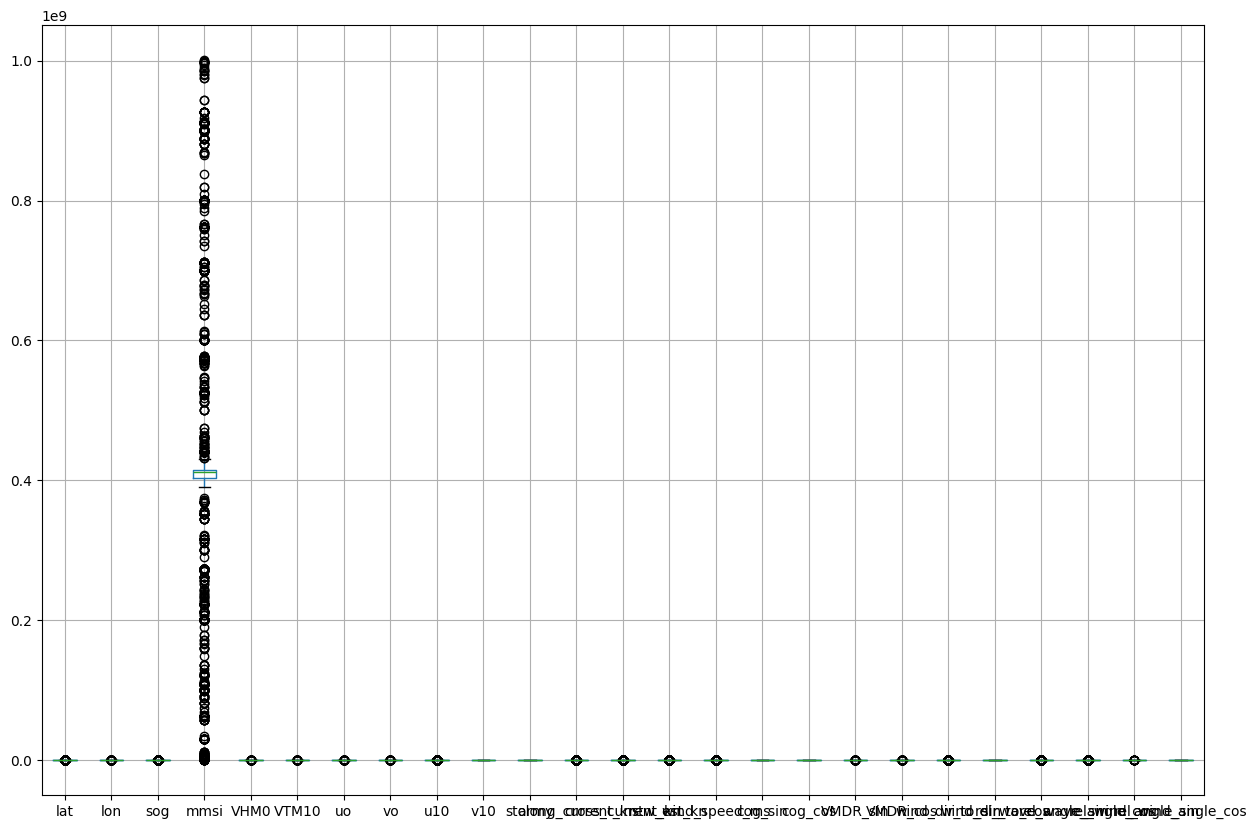

In [37]:
# Comprehensive boxplot analysis

df_final.boxplot(column=df_final.select_dtypes(include=[np.number]).columns.tolist(), figsize=(15,10))

Dataset shape: (8000, 31)
Visualizing 24 numeric columns

=== HISTOGRAMS OF ALL VARIABLES ===


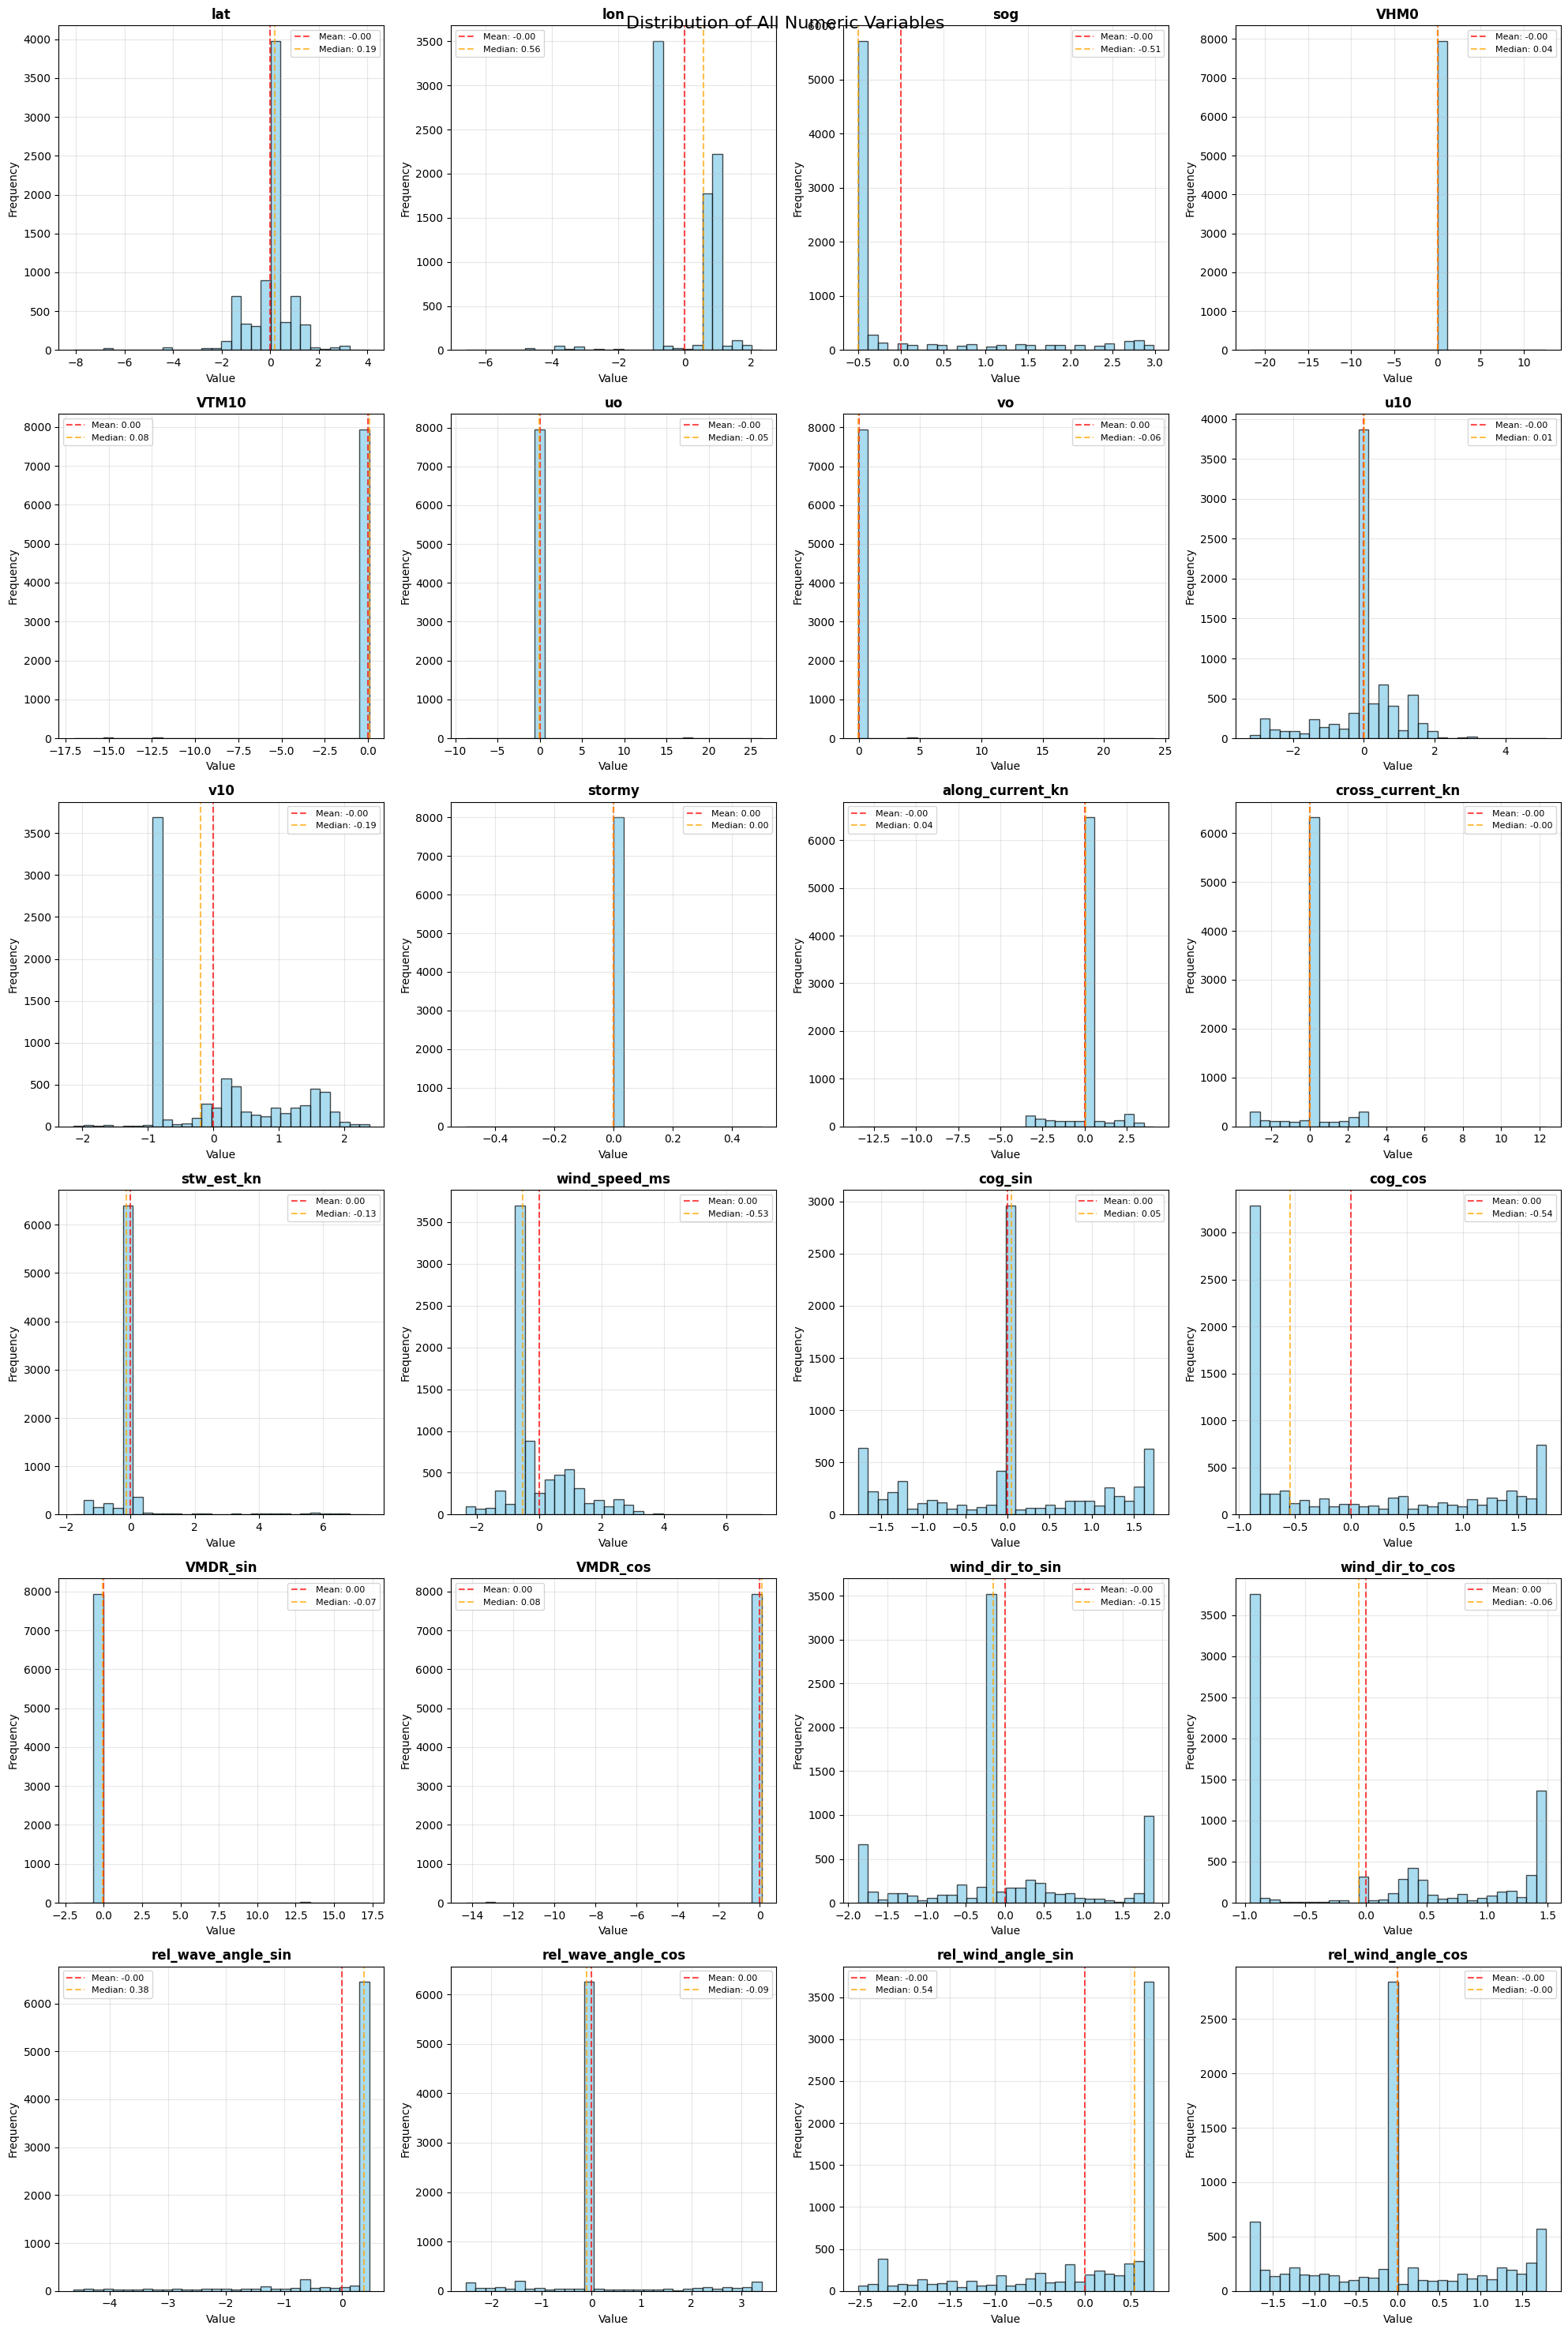

In [ ]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Get numeric columns only
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
exclude_viz = ['mmsi']  # Exclude ID columns
viz_cols = [col for col in numeric_cols if col not in exclude_viz]

print(f"Dataset shape: {df_final.shape}")
print(f"Visualizing {len(viz_cols)} numeric columns")

# === 1. CLEAN HISTOGRAMS ===
print("\n=== HISTOGRAMS OF ALL VARIABLES ===")

# Calculate grid dimensions
n_cols = len(viz_cols)
ncols = 4  # 4 columns per row
nrows = (n_cols + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
fig.suptitle('Distribution of All Numeric Variables', fontsize=16, y=0.98)

# Flatten axes for easier indexing
if nrows == 1:
    axes = axes if ncols > 1 else [axes]
else:
    axes = axes.flatten()

for i, col in enumerate(viz_cols):
    if i < len(axes):
        # Plot histogram with better styling
        axes[i].hist(df_final[col].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        # Add basic stats as text
        mean_val = df_final[col].mean()
        median_val = df_final[col].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
        axes[i].legend(fontsize=8)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# === 2. SUMMARY STATISTICS TABLE ===
print("\n=== COMPREHENSIVE SUMMARY STATISTICS ===")

summary_stats = df_final[viz_cols].describe()
print(summary_stats.round(3))

# Missing value analysis
print(f"\n=== MISSING VALUES ANALYSIS ===")
missing_analysis = pd.DataFrame({
    'Column': viz_cols,
    'Missing_Count': [df_final[col].isnull().sum() for col in viz_cols],
    'Missing_Percent': [df_final[col].isnull().sum() / len(df_final) * 100 for col in viz_cols],
    'Data_Type': [df_final[col].dtype for col in viz_cols]
})
missing_analysis = missing_analysis.sort_values('Missing_Percent', ascending=False)
print(missing_analysis.round(2))


=== COMPREHENSIVE SUMMARY STATISTICS ===
            lat       lon       sog      VHM0     VTM10        uo        vo  \
count  8000.000  8000.000  8000.000  8000.000  8000.000  8000.000  8000.000   
mean     -0.000    -0.000    -0.000    -0.000     0.000    -0.000     0.000   
std       1.000     1.000     1.000     1.000     1.000     1.000     1.000   
min      -8.098    -6.599    -0.506   -21.712   -17.033    -8.755    -0.063   
25%      -0.230    -0.874    -0.506     0.040     0.076    -0.054    -0.063   
50%       0.188     0.560    -0.506     0.040     0.076    -0.054    -0.063   
75%       0.188     0.901    -0.157     0.040     0.076    -0.054    -0.063   
max       4.076     2.312     2.984    12.564     0.076    26.263    24.063   

            u10       v10  stormy  ...   cog_sin   cog_cos  VMDR_sin  \
count  8000.000  8000.000  8000.0  ...  8000.000  8000.000  8000.000   
mean     -0.000    -0.000     0.0  ...     0.000     0.000     0.000   
std       1.000     1.000     


=== CORRELATION ANALYSIS ===
Variables for correlation analysis: ['VHM0', 'wind_speed_ms', 'sog', 'lat', 'lon', 'cog_sin', 'cog_cos', 'VMDR_sin', 'VMDR_cos']


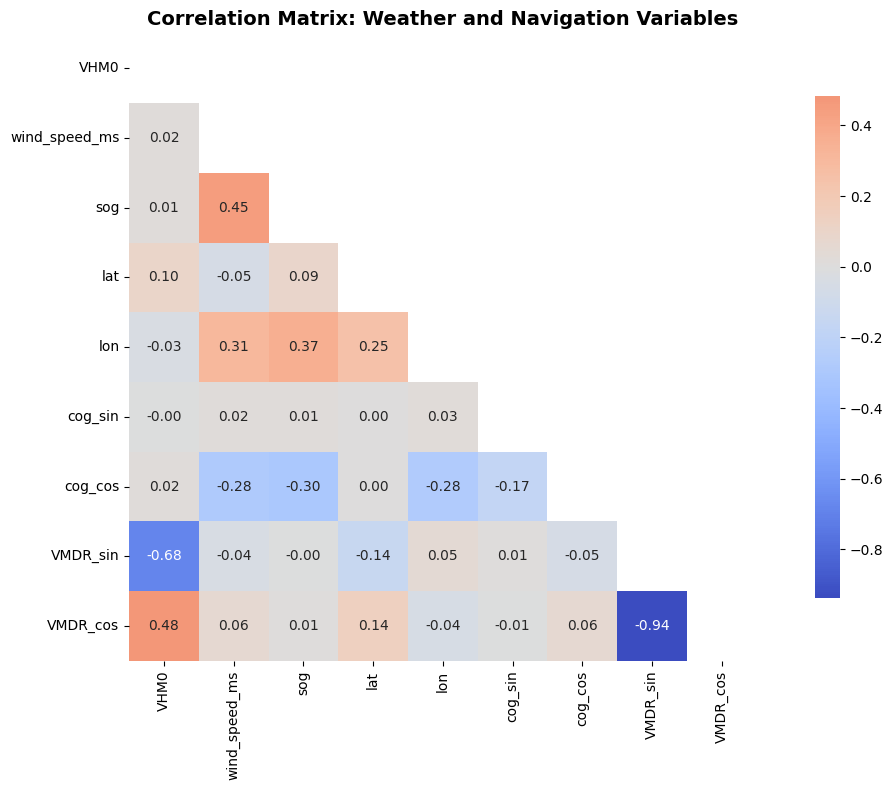


=== STRONGEST CORRELATIONS ===
Top 10 strongest correlations:
  VMDR_sin ↔ VMDR_cos: -0.938
  VHM0 ↔ VMDR_sin: -0.679
  VHM0 ↔ VMDR_cos: 0.483
  wind_speed_ms ↔ sog: 0.446
  sog ↔ lon: 0.366
  wind_speed_ms ↔ lon: 0.309
  sog ↔ cog_cos: -0.305
  wind_speed_ms ↔ cog_cos: -0.277
  lon ↔ cog_cos: -0.277
  lat ↔ lon: 0.253


In [ ]:
# === 3. CORRELATION HEATMAP ===
print("\n=== CORRELATION ANALYSIS ===")

# Select key variables WITHOUT stormy
key_vars = ['VHM0', 'wind_speed_ms', 'sog', 'lat', 'lon'] + \
           [col for col in viz_cols if '_sin' in col or '_cos' in col][:4]

available_key_vars = [col for col in key_vars if col in df_final.columns]

# Print what variables we're analyzing
print(f"Variables for correlation analysis: {available_key_vars}")

if len(available_key_vars) > 2:
    plt.figure(figsize=(12, 8))
    correlation_matrix = df_final[available_key_vars].corr()
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) 
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    
    plt.title('Correlation Matrix: Weather and Navigation Variables', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print highest correlations
    print(f"\n=== STRONGEST CORRELATIONS ===")
    # Get all correlations and sort by absolute value
    corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            corr = correlation_matrix.iloc[i, j]
            corr_pairs.append((var1, var2, corr))
    
    # Sort by absolute correlation value
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print("Top 10 strongest correlations:")
    for var1, var2, corr in corr_pairs[:10]:
        print(f"  {var1} ↔ {var2}: {corr:.3f}")

In [ ]:
# === 4. DATA OVERVIEW TABLE ===
print(f"\n=== DATA OVERVIEW ===")
print(f"{'='*60}")
print(f"Dataset Shape: {df_final.shape[0]:,} rows × {df_final.shape[1]} columns")
print(f"Memory Usage: {df_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Date Range: {df_final['ts_utc'].min()} to {df_final['ts_utc'].max()}")

# Column type breakdown
dtype_summary = df_final.dtypes.value_counts()
print(f"\nColumn Types:")
for dtype, count in dtype_summary.items():
    print(f"  {dtype}: {count} columns")

# Geographic extent
print(f"\nGeographic Coverage:")
print(f"  Latitude: {df_final['lat'].min():.3f}° to {df_final['lat'].max():.3f}°")
print(f"  Longitude: {df_final['lon'].min():.3f}° to {df_final['lon'].max():.3f}°")

# Key statistics
if 'VHM0' in df_final.columns:
    stormy_pct = (df_final['stormy'].sum() / len(df_final) * 100) if 'stormy' in df_final.columns else 0
    print(f"\nWeather Conditions:")
    print(f"  Max Wave Height: {df_final['VHM0'].max():.2f}m")
    print(f"  Stormy Conditions: {stormy_pct:.1f}% of records")

if 'wind_speed_ms' in df_final.columns:
    print(f"  Max Wind Speed: {df_final['wind_speed_ms'].max():.2f} m/s")

print(f"{'='*60}")


=== DATA OVERVIEW ===
Dataset Shape: 8,000 rows × 31 columns
Memory Usage: 2.26 MB
Date Range: 2025-03-08 06:20:00 to 2025-03-21 13:30:00

Column Types:
  float64: 24 columns
  bool: 4 columns
  object: 1 columns
  int64: 1 columns
  datetime64[ns]: 1 columns

Geographic Coverage:
  Latitude: -8.098° to 4.076°
  Longitude: -6.599° to 2.312°

Weather Conditions:
  Max Wave Height: 12.56m
  Stormy Conditions: 0.0% of records
  Max Wind Speed: 7.14 m/s


<h2>Clustering</h2>

Clustering dataset shape: (8000, 28)
Columns for clustering: ['lat', 'lon', 'sog', 'VHM0', 'VTM10', 'uo', 'vo', 'u10', 'v10', 'stormy', 'along_current_kn', 'cross_current_kn', 'stw_est_kn', 'wind_speed_ms', 'cog_sin', 'cog_cos', 'VMDR_sin', 'VMDR_cos', 'wind_dir_to_sin', 'wind_dir_to_cos', 'rel_wave_angle_sin', 'rel_wave_angle_cos', 'rel_wind_angle_sin', 'rel_wind_angle_cos', 'vessel_type_carrier', 'vessel_type_fishing', 'sea_sector_following', 'sea_sector_head']
Final numeric dataset shape: (8000, 24)

=== ELBOW METHOD ANALYSIS ===
K=1: SSE=184000
K=2: SSE=149165
K=3: SSE=124137
K=4: SSE=110154
K=5: SSE=99014
K=6: SSE=91630
K=7: SSE=83429
K=8: SSE=74971
K=9: SSE=69129
K=10: SSE=64666


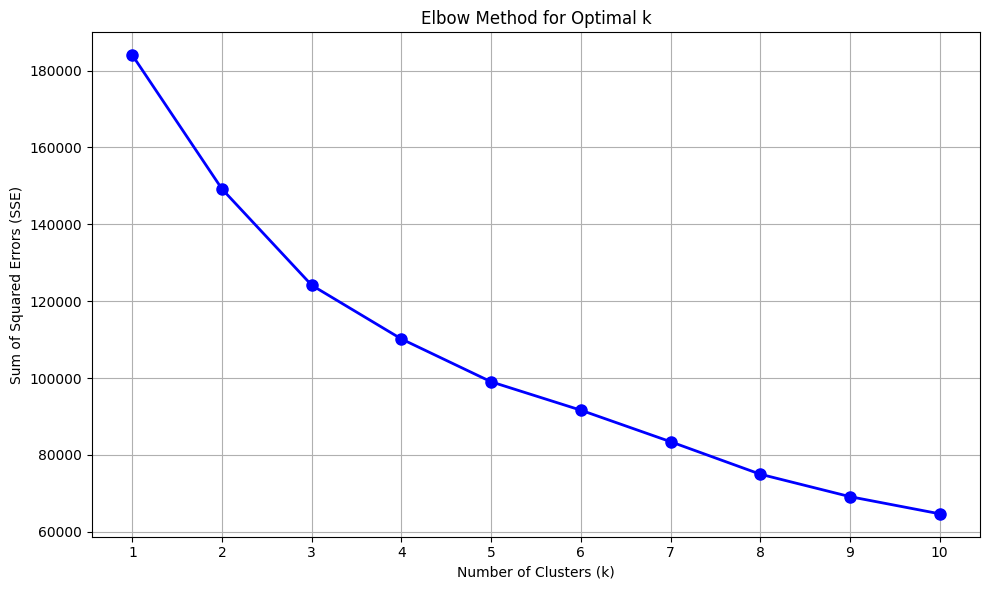


Look at the elbow plot to determine optimal k visually
Chose K=4 as the 'elbow' point where SSE reduction starts to level off


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Exclude the first column (timestamp) and any other non-numeric columns
exclude_cols = ['ts_utc', 'mmsi', '_t']  
df_clustering = df_final.drop(columns=[col for col in exclude_cols if col in df_final.columns])

print(f"Clustering dataset shape: {df_clustering.shape}")
print(f"Columns for clustering: {list(df_clustering.columns)}")

# Remove any remaining non-numeric columns
df_clustering = df_clustering.select_dtypes(include=[np.number])
print(f"Final numeric dataset shape: {df_clustering.shape}")

# === ELBOW METHOD ===
print("\n=== ELBOW METHOD ANALYSIS ===")

SSE = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, max_iter=300, tol=0.0001, n_init=10, random_state=99)
    kmeans.fit(df_clustering)
    SSE.append(kmeans.inertia_)
    print(f"K={k}: SSE={kmeans.inertia_:.0f}")

# === PLOTTING ===
plt.figure(figsize=(10, 6))

# Elbow plot
plt.plot(k_range, SSE, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.xticks(k_range)

plt.tight_layout()
plt.show()

print(f"\nLook at the elbow plot to determine optimal k visually")
print(f"Chose K=4 as the 'elbow' point where SSE reduction starts to level off")

In [ ]:
# performing k-means clustering with k=4
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, max_iter=300, tol=0.0001, n_init=10, random_state=99)
kmeans.fit(df_clustering)
df_final['cluster'] = kmeans.labels_
cluster_center = kmeans.cluster_centers_
cluster_center

array([[ -0.18023689,   0.79996345,   0.02725326,   0.03971369,
          0.07615494,  -0.05403907,  -0.06311946,   0.33271021,
          0.57177575,   0.        ,  -2.043377  ,  -1.51243425,
          1.11128105,   0.10810156,   1.04815934,  -0.20533969,
         -0.07353328,   0.07890034,   0.54558075,   0.63602541,
         -1.87382809,   2.72895593,  -0.58399059,   0.07100667],
       [ -0.12573813,  -0.56717511,  -0.44565996,   0.03971369,
          0.07615494,  -0.04998467,  -0.06297382,   0.22689205,
         -0.6588128 ,   0.        ,   0.17225265,   0.12261845,
         -0.20924886,  -0.50097963,  -0.10922663,   0.35000944,
         -0.07253502,   0.0733383 ,   0.17896374,  -0.67813939,
          0.18608978,  -0.23062552,  -0.21950347,  -0.0873734 ],
       [ -1.82165742,   0.58734156,  -0.07378512,  -7.29689446,
        -12.99815036,   8.89185123,  10.81587736,   0.48937453,
          0.37955537,   0.        ,  -0.43328537,   0.35186047,
         -0.06734034,  -0.6312468 ,   

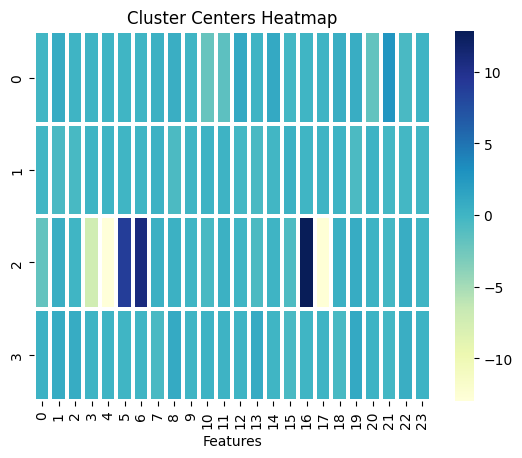

In [ ]:
import seaborn as sns 
sns.heatmap(cluster_center, linewidths=1.5, cmap="YlGnBu")
plt.title('Cluster Centers Heatmap')
plt.xlabel('Features')  
plt.show()